<a href="https://colab.research.google.com/github/AshHydroCoder/GRACE-Downscaler/blob/Branch1/Making_raw_files_for_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install cftime
!pip install metpy
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.9/409.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 50.3 MB/s eta 0:00:00


In [17]:
import rioxarray
import numpy as np
from numpy import *
import xarray as xr
import metpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Missing Month List of GRACE

In [7]:
grace_nc ='/content/drive/MyDrive/Thesis/GRACE_Clipped_converted.nc'
G_dataset = xr.open_dataset(grace_nc)
months_missing = G_dataset.attrs.get('months_missing', 'Attribute not found')
dates = months_missing.replace(",", ";").split(";")
missing_dates = [(int(date.split("-")[0]), int(date.split("-")[1])) for date in dates]
missing_dates = [pd.Timestamp(year=year, month=month, day=1) for year, month in missing_dates]
#print(missing_dates)
#G_dataset_clip = G_dataset.sel(time=slice('2003-02-01','2020-12-31'))
#G_dataset_clip = G_dataset_clip[['lwe_thickness']]
#df1 = G_dataset_clip.to_dataframe().reset_index()
# Export to CSV
#df1.to_csv('D:/Masters/Thesis/Data/RFM/'+what+'.csv', index=False)
#missing_dates


# Load Shape

In [8]:
nepal_shp = gpd.read_file('/content/drive/MyDrive/Thesis/Cluster/cluster_5_2.shp')
nepal_shp = nepal_shp.set_crs('epsg:4326')

## Exclude times not available in GRACE

## Raw files for RFM

### Precipitation

In [11]:
pr_nc ='/content/drive/MyDrive/Thesis/REGRID/precipitation.nc'
pr_dataset = xr.open_dataset(pr_nc)
pr_dataset = pr_dataset.rio.write_crs('epsg:4326')
pr_dataset = pr_dataset.rio.clip(nepal_shp.geometry,all_touched=True)
pr_dataset = pr_dataset.rename({'lon':'x','lat':'y'})
pr_dataset = pr_dataset.transpose('time','x', 'y')
print(pr_dataset)

<xarray.Dataset> Size: 99kB
Dimensions:        (time: 252, y: 4, x: 12)
Coordinates:
  * time           (time) object 2kB 2003-01-01 00:00:00 ... 2023-12-01 00:00:00
  * y              (y) float64 32B 26.38 26.62 26.88 27.12
  * x              (x) float64 96B 85.38 85.62 85.88 86.12 ... 87.62 87.88 88.12
    spatial_ref    int64 8B 0
Data variables:
    precipitation  (time, x, y) float64 97kB nan 0.0355 0.03775 ... nan nan nan
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/07;\nDOIa...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-06-15 08:35:48 GMT Hyrax-1.16.3 htt...


In [12]:
pr_dataset['time'] = pd.to_datetime(pr_dataset.indexes['time'].to_datetimeindex())  #if the time is not in standard format

time_index = pd.to_datetime(pr_dataset['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for timestamp in missing_dates:
    year = timestamp.year
    month = timestamp.month
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_dataset = pr_dataset.sel(time=mask[mask].index)
filtered_dataset = filtered_dataset.sel(time=slice('2003-02-01','2016-12-31'))

pr_df = filtered_dataset.to_dataframe().reset_index()
pr_df = pr_df.drop(columns='spatial_ref')
pr_df = pr_df.sort_values(by=['time','x'])
pr_df


<ipython-input-12-09fcd489e96d>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  pr_dataset['time'] = pd.to_datetime(pr_dataset.indexes['time'].to_datetimeindex())  #if the time is not in standard format


,time,y,x,precipitation
0,2003-02-01,26.375,85.375,NaN
12,2003-02-01,26.625,85.375,0.0400
24,2003-02-01,26.875,85.375,0.0555
36,2003-02-01,27.125,85.375,NaN
1,2003-02-01,26.375,85.625,NaN
...,...,...,...,...
7198,2016-12-01,27.125,87.875,NaN
7163,2016-12-01,26.375,88.125,0.0010
7175,2016-12-01,26.625,88.125,NaN
7187,2016-12-01,26.875,88.125,NaN


In [13]:
# Export to CSV
pr_df.to_csv('/content/drive/MyDrive/Thesis/RFM/Training/precipitation.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# Transpose the dataset to switch lat (y) and lon (x)
pr_dataset_transposed = pr_dataset.precipitation.isel(time=121).transpose('y', 'x')
pr_dataset_transposed.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

#num_panels = GR_Clip.lwe_thickness.isel(time = 1).size
#print(num_panels)

In [ ]:
file_path_nc ="D:/Masters/Thesis/Data/Combined_IMERG.nc4"
ppt = xr.open_dataset(file_path_nc)
ppt = ppt.rio.write_crs('epsg:4326')
ppt = ppt.rio.clip(nepal_shp.geometry,all_touched=True)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# Transpose the dataset to switch lat (y) and lon (x)
ppt_tr = ppt.precipitation.isel(time=121).transpose('lat', 'lon')
ppt_tr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

### CHIRPS

In [ ]:
chirps_path = "D:\Masters\Thesis\Data\CHIRPS.nc"
CHIRPS = xr.open_dataset(chirps_path)
CHIRPS = CHIRPS.rename({'longitude':'x','latitude':'y'})
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
CHIRPS_regrid = CHIRPS.interp(y = regrid_lat, x = regrid_lon,method='slinear')
CHIRPS_regrid

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Hp\AppData\Local\Temp\ipykernel_8460\1210551659.py:1: SyntaxWarning: invalid escape sequence '\M'
  chirps_path = "D:\Masters\Thesis\Data\CHIRPS.nc"


<xarray.Dataset>
Dimensions:  (time: 252, y: 44, x: 64)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2020-12-31
  * y        (y) float64 21.12 21.38 21.62 21.88 ... 31.12 31.38 31.62 31.88
  * x        (x) float64 76.12 76.38 76.62 76.88 ... 91.12 91.38 91.62 91.88
Data variables:
    precip   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [ ]:
CHIRPS_25 = CHIRPS_regrid.rio.write_crs('epsg:4326')
CHIRPS_25 = CHIRPS_25.rio.clip(nepal_shp.geometry,all_touched=True)
CHIRPS_25

<xarray.Dataset>
Dimensions:      (time: 252, y: 4, x: 12)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2020-12-31
  * y            (y) float64 26.38 26.62 26.88 27.12
  * x            (x) float64 85.38 85.62 85.88 86.12 ... 87.38 87.62 87.88 88.12
    spatial_ref  int32 0
Data variables:
    precip       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [ ]:
#CHIRPS_25['time'] = pd.to_datetime(CHIRPS_25.indexes['time'].to_datetimeindex())  #if the time is not in standard format

time_index = pd.to_datetime(CHIRPS_25['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for timestamp in missing_dates:
    year = timestamp.year
    month = timestamp.month
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_CHIRPS = CHIRPS_25.sel(time=mask[mask].index)
filtered_CHIRPS = filtered_CHIRPS.sel(time=slice('2003-02-01','2016-12-31'))

CHIRPS_DF = filtered_CHIRPS.to_dataframe().reset_index()
CHIRPS_DF = CHIRPS_DF.drop(columns='spatial_ref')
CHIRPS_DF = CHIRPS_DF.sort_values(by=['time','x'])
CHIRPS_DF
# Export to CSV
CHIRPS_DF.to_csv(f'D:/Masters/Thesis_New/Terai/RFM/chirps.csv', index=False)


### FLDAS

#### Automate for FLDAS

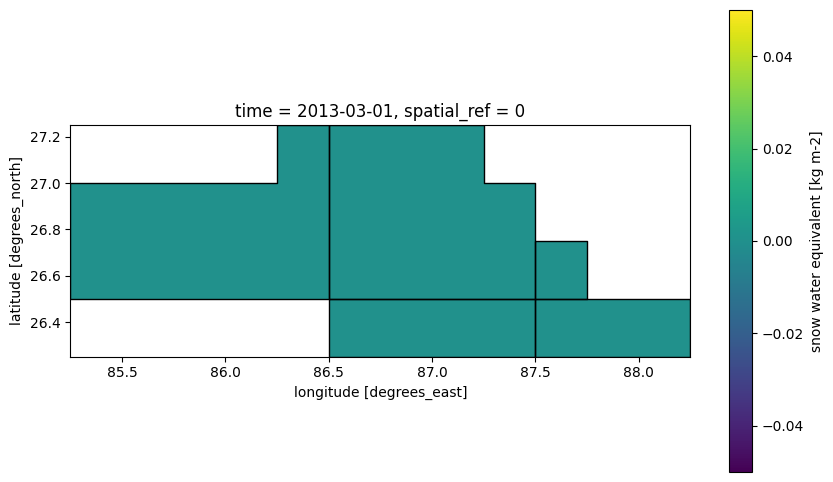

Exported: /content/drive/MyDrive/Thesis/RFM/Training/SWE_inst.csv


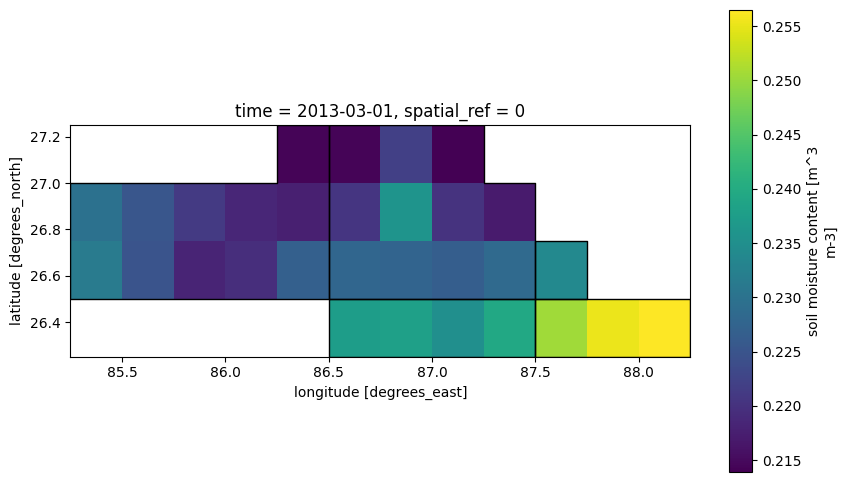

Exported: /content/drive/MyDrive/Thesis/RFM/Training/SM.csv


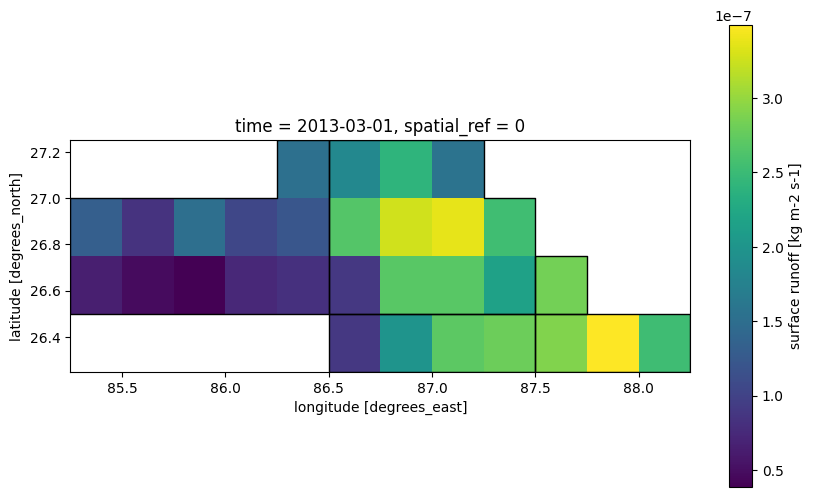

Exported: /content/drive/MyDrive/Thesis/RFM/Training/Qs_tavg.csv


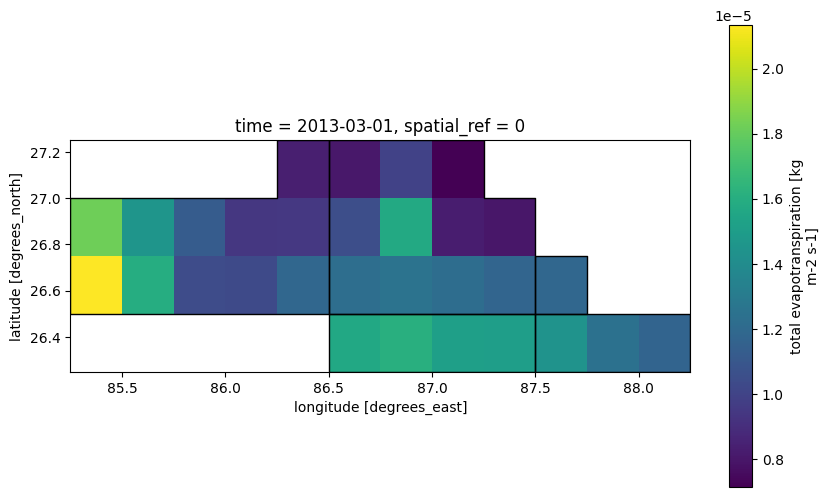

Exported: /content/drive/MyDrive/Thesis/RFM/Training/Evap_tavg.csv


In [18]:
# Needs FLDAS data that are exported to 0.25 degree resolution in a single folder
# Define the folder containing the .nc files and the shapefile
nc_folder = '/content/drive/MyDrive/Thesis/REGRID/FLDAS'
output_folder = '/content/drive/MyDrive/Thesis/RFM/Training'

# Load the shapefile
#nepal_shp = gpd.read_file(shapefile_path)

# List all .nc files in the folder
nc_files = [f for f in os.listdir(nc_folder) if f.endswith('.nc')]

# Loop through each .nc file
for nc_file in nc_files:
    # Define the full path of the .nc file
    file_path_nc = os.path.join(nc_folder, nc_file)

    # Open the dataset
    ev_dataset = xr.open_dataset(file_path_nc)

    # Assign the coordinate system and clip the data using the shapefile
    ev_dataset = ev_dataset.rio.write_crs('epsg:4326')
    ev_dataset = ev_dataset.rio.clip(nepal_shp.geometry, all_touched=True)

    # Rename the dimensions and transpose the dataset
    ev_dataset = ev_dataset.rename({'lon': 'x', 'lat': 'y'})
    ev_dataset = ev_dataset.transpose('time', 'x', 'y')

    # Plot the data for a specific time (you can adjust the time step if needed)
    fig, ax = plt.subplots(figsize=(10, 6))
    ev_dataset_transposed = ev_dataset[list(ev_dataset.data_vars)[0]].isel(time=121).transpose('y', 'x')
    ev_dataset_transposed.plot(ax=ax)
    nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')
    plt.show()

    # Convert time to a standard format if needed
   # if 'time' in ev_dataset.coords:
        #ev_dataset['time'] = pd.to_datetime(ev_dataset.indexes['time'].to_datetimeindex())

    # Define missing dates if needed and create a mask to filter the dataset
    time_index = pd.to_datetime(ev_dataset['time'].values)
    mask = pd.Series(True, index=time_index)

    # Filter the dataset if you have a list of missing_dates (adjust as needed)
    for timestamp in missing_dates:
        year, month = timestamp.year, timestamp.month
        mask &= ~((time_index.year == year) & (time_index.month == month))

    # Apply the mask and select the desired time range
    ev_filtered_dataset = ev_dataset.sel(time=mask[mask].index)
    ev_filtered_dataset = ev_filtered_dataset.sel(time=slice('2003-02-01', '2016-12-31'))

    # Convert the dataset to a dataframe, drop unnecessary columns, and sort it
    ev_df = ev_filtered_dataset.to_dataframe().reset_index()
    if 'spatial_ref' in ev_df.columns:
        ev_df = ev_df.drop(columns='spatial_ref')
    ev_df = ev_df.sort_values(by=['time', 'x'])

    # Define the output file path with the same name as the .nc file but with .csv extension
    output_file_csv = os.path.join(output_folder, nc_file.replace('.nc', '.csv'))

    # Export the dataframe to a CSV file
    ev_df.to_csv(output_file_csv, index=False)

    print(f'Exported: {output_file_csv}')


In [ ]:
import xarray as xr
import pandas as pd

# Define the start and end date for filtering
start_date = '2003-02-01'
end_date = '2016-12-31'

# List of variables in the dataset
vars = [variable for variable in FLDAS_regrid.variables]
print(vars)

# Dictionary to store individual data arrays for each soil moisture component
dynamic_vars = {}
for i in range(8, 12):
    dynamic_vars["iget" + vars[i]] = FLDAS_regrid[vars[i]]

# Define a time-based mask to filter out missing dates
def get_time_mask(time_values, missing_dates):
    time_index = pd.to_datetime(time_values)
    mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

    for timestamp in missing_dates:
        year = timestamp.year
        month = timestamp.month
        # Exclude dates that match the missing year and month
        mask &= ~((time_index.year == year) & (time_index.month == month))

    return mask

# Export each component to a CSV file, sorted by longitude
for key, da in dynamic_vars.items():
    # Apply time mask to filter missing dates
    time_mask = get_time_mask(da['time'].values, missing_dates)
    da_filtered = da.sel(time=time_mask[time_mask].index)

    # Apply date range filter
    da_filtered = da_filtered.sel(time=slice(start_date, end_date))

    # Convert to DataFrame, reset index, and sort by 'lon'
    df = da_filtered.to_dataframe().reset_index()
    df = df.sort_values(by=['time','x'])
    output_file = f"D:/Masters/Thesis_New/Terai/RFM/{key}.csv"
    df.to_csv(output_file, index=False)
    print(f"Exported {key} to {output_file}")



['time', 'x', 'y', 'spatial_ref', 'Evap_tavg', 'Qs_tavg', 'SWE_inst', 'Tair_f_tavg', 'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', 'SoilMoi100_200cm_tavg']
Exported igetSoilMoi00_10cm_tavg to D:/Masters/Thesis_New/Terai/RFM/igetSoilMoi00_10cm_tavg.csv
Exported igetSoilMoi10_40cm_tavg to D:/Masters/Thesis_New/Terai/RFM/igetSoilMoi10_40cm_tavg.csv
Exported igetSoilMoi40_100cm_tavg to D:/Masters/Thesis_New/Terai/RFM/igetSoilMoi40_100cm_tavg.csv
Exported igetSoilMoi100_200cm_tavg to D:/Masters/Thesis_New/Terai/RFM/igetSoilMoi100_200cm_tavg.csv


###  NDVI

In [19]:
file_path_nc ="/content/drive/MyDrive/Thesis/REGRID/NDVI_2003_2023.nc"
dataset = xr.open_dataset(file_path_nc)
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
NDVI = dataset['NDVI'].interp(lat = regrid_lat,lon=regrid_lon,method='slinear')
NDVI = NDVI.rio.write_crs('epsg:4326')
NDVI = NDVI.rename({'lon':'x','lat':'y'})
NDVI = NDVI.rio.clip(nepal_shp.geometry,all_touched=True)
NDVI = NDVI.transpose('time','x', 'y')
NDVI
time_index = pd.to_datetime(NDVI['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for timestamp in missing_dates:
    year = timestamp.year
    month = timestamp.month
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_dataset = NDVI.sel(time=mask[mask].index)
filtered_dataset = filtered_dataset.sel(time=slice('2003-02-01','2016-12-31'))

df = filtered_dataset.to_dataframe().reset_index()
df
# Export to CSV
what = 'NDVI'
df.to_csv('/content/drive/MyDrive/Thesis/RFM/Training/NDVI.csv', index=False)



# GRACE

## Export GRACE into csv

In [20]:
file_path_nc ="/content/drive/MyDrive/Thesis/GRACE_Clipped_converted.nc"
G_dataset = xr.open_dataset(file_path_nc)
G_dataset = G_dataset.drop_vars('time_bounds')
G_dataset = G_dataset.rio.write_crs('epsg:4326')
G_dataset = G_dataset.rename({'lon':'x','lat':'y'})
G_dataset = G_dataset.rio.clip(nepal_shp.geometry,all_touched=True)
G_dataset_clip = G_dataset.sel(time=slice('2003-02-01','2016-12-31'))
G_dataset_clip = G_dataset_clip[['lwe_thickness']]
Gdf1 = G_dataset_clip.to_dataframe().reset_index()
Gdf1 = Gdf1.sort_values(by=['time', 'x'])
# Export to CSV
what = 'GRACE'
Gdf1.to_csv('/content/drive/MyDrive/Thesis/RFM/Training/GRACE.csv', index=False)
#missing_dates


## DEM

### elevation

In [23]:
import rioxarray
dem_file = "/content/drive/MyDrive/Thesis/REGRID/Metric DEM.tif"
dataset = rioxarray.open_rasterio(dem_file)

# Set the current CRS and reproject to EPSG:4326
dataset = dataset.rio.write_crs("EPSG:32645")  # Original CRS
dataset = dataset.rio.reproject("EPSG:4326")
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
dem = dataset.interp(y = regrid_lat,x=regrid_lon,method='slinear')

In [25]:
dem

<xarray.DataArray (band: 1, y: 4, x: 12)> Size: 384B
array([[[          nan,           nan,           nan,           nan,
                   nan,   65.95055977,   68.56908922,   67.77806452,
           65.        ,   63.32012856,   67.58764538,   67.55765324],
        [  68.98924283,   64.7603861 ,   66.61566411,   71.08350371,
           88.01250163,  116.30830343,   98.        ,   88.90309646,
          110.33254217,  112.93646142,           nan,           nan],
        [  83.86867198,   93.34292485,  111.88309284,  116.72266359,
          513.09269349,  415.32680398,  776.69201987,  835.12876038,
         1106.48500667,           nan,           nan,           nan],
        [          nan,           nan,           nan,           nan,
         1082.3431404 ,  579.64564665, 2337.72907418, 1052.1224156 ,
                   nan,           nan,           nan,           nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 32B 26.38 26.62 26.88 27.12
  * x            (x) float64 96B 85.38 85.62 85.88 86.12 ... 87.62 87.88 88.12
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0.0

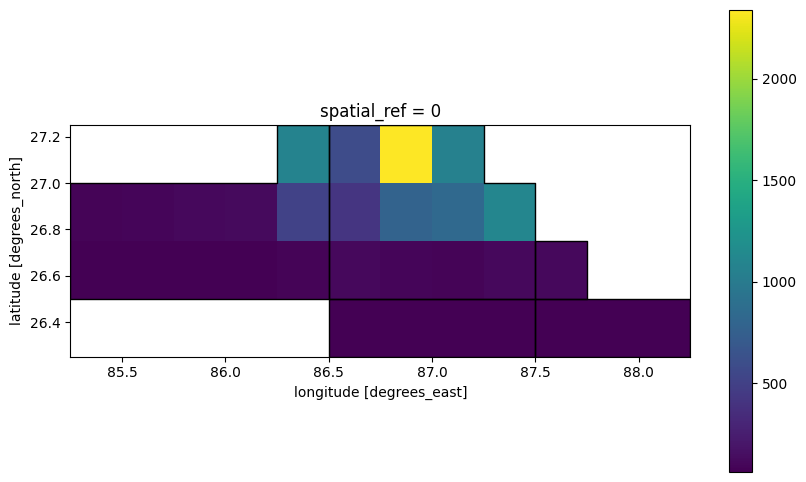

In [26]:
import rioxarray
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

dem = dem.squeeze(dim="band", drop=True)
dem = dem.rio.clip(nepal_shp.geometry,all_touched= True)
dem = dem.where(dem != 0, np.nan)
# Transpose the dataset to switch lat (y) and lon (x)
dem_tr = dem.transpose('y', 'x')
dem_tr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [28]:
dem.name = "elevation"
demdf = dem.to_dataframe().reset_index()
demdf = demdf.sort_values(by=['x','y'])
demdf
# Export to CSV
demdf.to_csv('/content/drive/MyDrive/Thesis/RFM/Training/DEM/elevation.csv', index=False)

### Slope

In [ ]:
import rioxarray
slope_file = "D:\Masters\Thesis_New\DEM\Slope.tif"
slope_ds = rioxarray.open_rasterio(slope_file)

# Set the current CRS and reproject to EPSG:4326
slope_ds = slope_ds.rio.write_crs("EPSG:32645")  # Original CRS
slope_ds = slope_ds.rio.reproject("EPSG:4326")
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
slope = slope_ds.interp(y = regrid_lat,x=regrid_lon,method='slinear')

In [ ]:
slope

In [ ]:
import rioxarray
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

slope = slope.squeeze(dim="band", drop=True)
slope = slope.rio.clip(nepal_shp.geometry,all_touched= True)
fill_value = slope.attrs.get('_FillValue', None)
slope = slope.where(slope != fill_value, np.nan)
#tolerance = 0.01
#slope = slope.where(~((slope > -9999 - tolerance) & (slope < -9999 + tolerance)), np.nan)

#slope = slope.where(slope != 0, np.nan)
# Transpose the dataset to switch lat (y) and lon (x)
slope_tr = slope.transpose('y', 'x')
slope_tr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [ ]:
slope.name = "slope"
slopedf = slope.to_dataframe().reset_index()
slopedf = slopedf.sort_values(by=['x','y'])
slopedf
# Export to CSV
slopedf.to_csv('D:/Masters/Thesis_New/Terai/RFM/slop.csv', index=False)

### Aspect

In [ ]:
import rioxarray
aspect_file = "D:\Masters\Thesis_New\DEM\Aspect.tif"
aspect_ds = rioxarray.open_rasterio(aspect_file)

# Set the current CRS and reproject to EPSG:4326
aspect_ds = aspect_ds.rio.write_crs("EPSG:32645")  # Original CRS
aspect_ds = aspect_ds.rio.reproject("EPSG:4326")
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
aspect = aspect_ds.interp(y = regrid_lat,x=regrid_lon,method='slinear')

In [ ]:
aspect

In [ ]:
import rioxarray
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

aspect = aspect.squeeze(dim="band", drop=True)
aspect = aspect.rio.clip(nepal_shp.geometry,all_touched= True)
fill_value = aspect.attrs.get('_FillValue', None)
aspect = aspect.where(aspect != fill_value, np.nan)
#tolerance = 0.01
#aspect = aspect.where(~((aspect > -9999 - tolerance) & (aspect < -9999 + tolerance)), np.nan)

#aspect = aspect.where(aspect != 0, np.nan)
# Transpose the dataset to switch lat (y) and lon (x)
aspect_tr = aspect.transpose('y', 'x')
aspect_tr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [ ]:
aspect.name = "aspect"
aspectdf = aspect.to_dataframe().reset_index()
aspectdf = aspectdf.sort_values(by=['x','y'])
aspectdf
# Export to CSV
aspectdf.to_csv('D:/Masters/Thesis_New/Terai/RFM/aspect.csv', index=False)

### Repeat

In [ ]:
import pandas as pd
import os

# Folder containing the CSV files
input_folder = '/content/drive/MyDrive/Thesis/RFM/Training/DEM'
output_folder = '/content/drive/MyDrive/Thesis/RFM/Training/'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Step 2: Create a date range from 2003-02-01 to 2016-12-31 (monthly frequency)
date_range = pd.date_range(start='2003-02-01', end='2016-12-31', freq='MS')

# Define missing dates and convert to datetime
missing_dates = pd.to_datetime(missing_dates, format='%Y-%m')
filtered_date_range = date_range[~date_range.isin(missing_dates)]

# Loop through each CSV file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        # Step 1: Read each original CSV file
        file_path = os.path.join(input_folder, file_name)
        original_data = pd.read_csv(file_path)

        # Step 5: Repeat the original data for each valid date (excluding the missing ones)
        extended_data = pd.concat([original_data] * len(filtered_date_range), ignore_index=True)
        extended_data['time'] = filtered_date_range.repeat(len(original_data)).values

        # Step 6: Export the new data with the time dimension to a new CSV file
        output_file = os.path.join(output_folder, f'extended_{file_name}')
        extended_data.to_csv(output_file, index=False)

        print(f"Processed and saved {output_file}")

print("All files have been processed and saved.")


# Check number of data in each CSV Files

In [ ]:
import os
import pandas as pd

# Path to the folder containing the CSV files
folder_path = '/content/drive/MyDrive/Thesis/RFM/Training'

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Print the file name and the number of rows
        print(f'File: {filename}, Number of rows: {len(df)}')


File: Evap_tavg.csv, Number of rows: 7200
File: extended_aspect.csv, Number of rows: 7200
File: extended_elevation.csv, Number of rows: 7200
File: extended_slop.csv, Number of rows: 7200
File: GRACE.csv, Number of rows: 7200
File: igetSoilMoi00_10cm_tavg.csv, Number of rows: 7200
File: igetSoilMoi100_200cm_tavg.csv, Number of rows: 7200
File: igetSoilMoi10_40cm_tavg.csv, Number of rows: 7200
File: igetSoilMoi40_100cm_tavg.csv, Number of rows: 7200
File: NDVI.csv, Number of rows: 7200
File: precipitation.csv, Number of rows: 7200
File: Qs_tavg.csv, Number of rows: 7200
File: SWE_inst.csv, Number of rows: 7200


# Combine the csv files

In [ ]:
import os
import pandas as pd

# Function to get the columns to copy from each CSV file
def select_columns(df, file_name):
    print(f"Available columns in {file_name}:")
    print(df.columns.tolist())

    # Ask the user for the column names they want to copy
    selected_columns = input("Enter the columns to copy (separated by commas): ").split(",")
    selected_columns = [col.strip() for col in selected_columns]  # Remove leading/trailing spaces
    return df[selected_columns]

# Folder where the CSV files are located
folder_path = '/content/drive/MyDrive/Thesis/RFM/Training/'

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Ask the user which columns to copy
        selected_data = select_columns(df, file_name)

        # Add the selected columns to the combined DataFrame
        combined_df = pd.concat([combined_df, selected_data], axis=1)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv("/content/drive/MyDrive/Thesis/RFM/Training/combined_csv_file_Cluster 5.csv", index=False)
print("Combined CSV file created: combined_csv_file.csv")


Available columns in Evap_tavg.csv:
['time', 'x', 'y', 'Evap_tavg']


Enter the columns to copy (separated by commas):  time, x, y, Evap_tavg


Available columns in extended_aspect.csv:
['y', 'x', 'spatial_ref', 'aspect', 'time']


Enter the columns to copy (separated by commas):  aspect


Available columns in extended_elevation.csv:
['y', 'x', 'spatial_ref', 'elevation', 'time']


Enter the columns to copy (separated by commas):  elevation


Available columns in extended_slop.csv:
['y', 'x', 'spatial_ref', 'slope', 'time']


Enter the columns to copy (separated by commas):  slope


Available columns in GRACE.csv:
['time', 'y', 'x', 'lwe_thickness', 'spatial_ref', 'WGS84']


Enter the columns to copy (separated by commas):  lwe_thickness


Available columns in igetSoilMoi00_10cm_tavg.csv:
['time', 'y', 'x', 'spatial_ref', 'SoilMoi00_10cm_tavg']


Enter the columns to copy (separated by commas):  SoilMoi00_10cm_tavg


Available columns in igetSoilMoi100_200cm_tavg.csv:
['time', 'y', 'x', 'spatial_ref', 'SoilMoi100_200cm_tavg']


Enter the columns to copy (separated by commas):  SoilMoi100_200cm_tavg


Available columns in igetSoilMoi10_40cm_tavg.csv:
['time', 'y', 'x', 'spatial_ref', 'SoilMoi10_40cm_tavg']


Enter the columns to copy (separated by commas):  SoilMoi10_40cm_tavg


Available columns in igetSoilMoi40_100cm_tavg.csv:
['time', 'y', 'x', 'spatial_ref', 'SoilMoi40_100cm_tavg']


Enter the columns to copy (separated by commas):  SoilMoi40_100cm_tavg


Available columns in NDVI.csv:
['time', 'x', 'y', 'spatial_ref', 'NDVI']


Enter the columns to copy (separated by commas):  NDVI


Available columns in precipitation.csv:
['time', 'y', 'x', 'precipitation']


Enter the columns to copy (separated by commas):  precipitation


Available columns in Qs_tavg.csv:
['time', 'x', 'y', 'Qs_tavg']


Enter the columns to copy (separated by commas):  Qs_tavg


Available columns in SWE_inst.csv:
['time', 'x', 'y', 'SWE_inst']


Enter the columns to copy (separated by commas):  SWE_inst


Combined CSV file created: combined_csv_file.csv


In [ ]:
path1 = "D:/Masters/Thesis/Data/RFM/combined_csv_file.csv"
csv = pd.read_csv(path1)
csv

# Predictor Model Data Preparation

### Missing Dates of GRACE

In [ ]:
what = 'GRACE_Clipped_converted'
file_path_nc ="D:/Masters/Thesis/Data/ReGrid/"+what + ".nc"
G_dataset = xr.open_dataset(file_path_nc)
months_missing = G_dataset.attrs.get('months_missing', 'Attribute not found')
dates = months_missing.replace(",", ";").split(";")
missing_dates = [(int(date.split("-")[0]), int(date.split("-")[1])) for date in dates]

### Target Resolution (FLDAS)

In [ ]:
FLDAS_path ="D:/Masters/Thesis/Data/Combined_FLDAS.nc"
FLDAS = xr.open_dataset(FLDAS_path)
FLDAS = FLDAS.rename({'X':'lon','Y':'lat'})
#FLDAS['time'] = pd.to_datetime(FLDAS.indexes['time'].to_datetimeindex())  #if the time is not in standard format

time_index = pd.to_datetime(FLDAS['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for year, month in missing_dates:
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
FLDAS_N = FLDAS.sel(time=mask[mask].index)
FLDAS_N = FLDAS_N.sel(time=slice('2003-02-01','2016-12-31'))
FLDAS_N
#FLDAS_N = FLDAS_N.drop(columns=['time','X','Y'])
#data_array - data_array.rename({'X':'lon','Y':'lat'})
#path = "D:\Masters\Thesis\Data\Predictor\SM.csv"
#FLDAS_N.to_csv(path,index = False)

#### Average SM and Export to csv

In [ ]:
# Save the regridded data to a NetCDF file
import xarray as xr
vars = [variable for variable in FLDAS_N.variables]
print(vars)
vars[8:12]
dynamic_vars = {}
for i in range(8, 12):
    dynamic_vars["iget" + vars[i]] = FLDAS_N[vars[i]]
average_data_array = None

# Loop through each DataArray in the dictionary and compute the mean
for key, da in dynamic_vars.items():
    if average_data_array is None:
        average_data_array = da
    else:
        average_data_array += da
average_data_array /= len(dynamic_vars)
average_data_array.name = "SM"
average_data_array
SM_df = average_data_array.to_dataframe().reset_index()
SM_df = SM_df.sort_values(by=['time', 'lon'])

SM_df_drop = SM_df.drop(columns=['time','lat','lon'])
path = "D:\Masters\Thesis\Data\Predictor\SM.csv"
SM_df_drop.to_csv(path,index = False)
SM_df


#### Other data from FLDAS

In [ ]:
vars = [variable for variable in FLDAS_N.variables]
i = 4
which  = vars[i]
what = FLDAS_N[vars[i]]
what_df = what.to_dataframe().reset_index()
what_df = what_df.sort_values(by=['time', 'lon'])

#what_df_drop = what_df.drop(columns=['time','lon','lat'])
path = "D:/Masters/Thesis/Data/Predictor/" + which + ".csv"
what_df.to_csv(path,index = False)
what_df

In [ ]:
# Ask for the index of the variable to export
index_to_export = int(input("Enter the index of the variable to export: "))

# Retrieve the variable name based on the index
var_name = vars[index_to_export]

# Extract the variable from the dataset
selected_var = FLDAS_N[var_name]

# Convert the selected variable to a DataFrame and reset index
selected_var_df = selected_var.to_dataframe().reset_index()

# Drop unnecessary columns (you can adjust this if needed)
selected_var_df = selected_var_df.drop(columns=['time', 'X', 'Y'])

# Dynamically generate the CSV file name based on the variable name
csv_path = f"D:/Masters/Thesis/Data/Predictor/{var_name}.csv"

# Export the DataFrame to CSV
selected_var_df.to_csv(csv_path, index=False)

print(f"Exported {var_name} to {csv_path}")
csv = pd.read_csv(csv_path)
csv

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
lst = xr.open_dataset('D:/Masters/Thesis/Data/Combined_FLDAS.nc')
variables = [variable for variable in lst.variables]
print(variables)
which = variables[6]
which
time = lst['time']
#display(time)
# Assuming lst is an xarray Dataset
#lst = lst.transpose('time', 'x', 'y')  # Transpose if necessary
# Check if lat/lon are correctly labeled, otherwise rename them
#lst = lst.rename({'lat': 'Y', 'lon': 'X'})
for yr in range(2004,2005):
  filt_time = time.sel(time=time.dt.year==yr)
  display(filt_time)
  fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
  axes = axes.flatten()
  i=1
  # Plot each month
  for t in filt_time:
      monthly_data = lst.sel(time=t)
      #print(t)
      # Assuming you want to plot the first variable in the dataset
      monthly_data[which].plot(ax=axes[i-1],cmap = 'viridis')
      #axes[i].set_title(f'Month {i}')
      i+=1

  # Adjust layout
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.4, wspace=0.4)
  #plt.savefig(f'/content/drive/MyDrive/Thesis_folder/pre_processed_data/IMERG/{yr}.png', bbox_inches='tight', dpi=300)
  plt.show()
countnan = lst[which].isnull().sum()
print(countnan)
print(which)

### Precipitation

In [ ]:
file_path_nc ="D:/Masters/Thesis/Data/Combined_IMERG.nc4"
ppt = xr.open_dataset(file_path_nc)
ppt['time'] = pd.to_datetime(ppt.indexes['time'].to_datetimeindex())  #if the time is not in standard format

time_index = pd.to_datetime(ppt['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for year, month in missing_dates:
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_ppt = ppt.sel(time=mask[mask].index)
filtered_ppt = filtered_ppt.sel(time=slice('2003-02-01','2020-12-31'))

regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)
ppt_new = filtered_ppt.interp( lat = regrid_lat,lon = regrid_lon, method='slinear')
ppt_df = ppt_new.to_dataframe().reset_index()
#ppt_df = ppt_df.sort_values(by=['time', 'lat'])
ppt_df_drop = ppt_df.drop(columns=['time','lon','lat'])
path = "D:\Masters\Thesis\Data\Predictor\ppt_df.csv"
ppt_df_drop.to_csv(path,index = False)
ppt_df


### NDVI

In [ ]:
file_path_nc ="D:/Masters/Thesis/Data/NDVI/NDVI_2003_2023.nc"
dataset = xr.open_dataset(file_path_nc)
regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)
NDVI = dataset['NDVI'].interp(lat = regrid_lat,lon=regrid_lon,method='slinear')
NDVI
time_index = pd.to_datetime(NDVI['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for year, month in missing_dates:
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_dataset = NDVI.sel(time=mask[mask].index)
filtered_dataset = filtered_dataset.sel(time=slice('2003-02-01','2020-12-31'))

NDVI_df = filtered_dataset.to_dataframe().reset_index()
#NDVI_df = NDVI_df.sort_values(by=['time', 'lat'])
NDVI_df_drop = NDVI_df.drop(columns=['time','lon','lat'])

# Export to CSV
what = 'NDVI'
NDVI_df_drop.to_csv('D:/Masters/Thesis/Data/Predictor/'+what+'.csv', index=False)
path = 'D:/Masters/Thesis/Data/Predictor/'+what+'.csv'
NDVI_df

## Check number of data in csv

In [ ]:
import os
import pandas as pd

# Path to the folder containing the CSV files
folder_path = 'D:/Masters/Thesis/Data/Predictor/'

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Print the file name and the number of rows
        print(f'File: {filename}, Number of rows: {len(df)}')

### DEM, Aspect and Slope

#### Visualize

#### Export to 0.25

In [ ]:
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt

# File paths
dem_file = 'D:/Masters/Thesis_New/DEM/DEM_0.25.tif'  # Path to your DEM file
shapefile_path = 'D:/Masters/Thesis_New/Study Area.shp'  # Path to your shapefile

# Load the shapefile
nepal_shp = gpd.read_file(shapefile_path)

# Load the DEM file and assign the CRS (if not already set)
dem = rioxarray.open_rasterio(dem_file)
dem = dem.rio.write_crs('epsg:4326')

# Clip the DEM file using the shapefile
dem_clipped = dem.rio.clip(nepal_shp.geometry, all_touched=True)

# Plot the clipped DEM
fig, ax = plt.subplots(figsize=(10, 6))
dem_clipped.plot(ax=ax)
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')  # Plot the shapefile boundaries
plt.title("Clipped DEM")
plt.show()

# Save the clipped DEM if needed
output_dem_file = 'D:/Masters/Thesis_New/DEM/clipped.tif'
dem_clipped.rio.to_raster(output_dem_file)


In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Open the DEM dataset
file_path_nc = "D:/Masters/Thesis_New/DEM/clipped original.tif"
DEM = xr.open_dataset(file_path_nc)

# Define the regridding lat and lon values with the desired resolution
regrid_lat = np.arange(26.125, 29.625, 0.25)
regrid_lon = np.arange(79.875, 88.375, 0.25)

# Perform interpolation with 'nearest' method
regrid_DEM = DEM.interp(x=regrid_lon, y=regrid_lat, method='nearest')
regrid_DEM = regrid_DEM.rename({'x': 'lon', 'y': 'lat'})

# Extract the data array from the regridded DEM
data_array = regrid_DEM['band_data'].squeeze()  # Remove extra dimensions if any

# Flip the array vertically (north-south direction)
data_array_flipped = np.flipud(data_array)

# Define the transform (affine) based on regridded lat/lon
transform = from_origin(west=min(regrid_lon), north=max(regrid_lat), xsize=0.25, ysize=0.25)

# Export the regridded DEM to a GeoTIFF file
DEM_0_25_path = 'D:/Masters/Thesis_New/DEM/DEM_0.25_2.tif'
with rasterio.open(
    DEM_0_25_path,
    'w',  # Write mode
    driver='GTiff',
    height=data_array_flipped.shape[0],
    width=data_array_flipped.shape[1],
    count=1,
    dtype=data_array_flipped.dtype,
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(data_array_flipped, 1)  # Write flipped data to the first band
data_array_flipped

#### Export to 0.1

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Open the DEM dataset
file_path_nc = "D:/Masters/Thesis/Data/newdem.tif"
DEM = xr.open_dataset(file_path_nc)

# Define the regridding lat and lon values with the desired resolution
regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)

# Perform interpolation with 'nearest' method
regrid_DEM = DEM.interp(x=regrid_lon, y=regrid_lat, method='nearest')
regrid_DEM = regrid_DEM.rename({'x': 'lon', 'y': 'lat'})

# Extract the data array from the regridded DEM
data_array = regrid_DEM['band_data'].squeeze()  # Remove extra dimensions if any

# Flip the array vertically (north-south direction)
data_array_flipped = np.flipud(data_array)

# Define the transform (affine) based on regridded lat/lon
transform = from_origin(west=min(regrid_lon), north=max(regrid_lat), xsize=0.1, ysize=0.1)

# Export the regridded DEM to a GeoTIFF file
DEM_0_25_path = 'D:/Masters/Thesis/Data/DEM_0.1.tif'
with rasterio.open(
    DEM_0_25_path,
    'w',  # Write mode
    driver='GTiff',
    height=data_array_flipped.shape[0],
    width=data_array_flipped.shape[1],
    count=1,
    dtype=data_array_flipped.dtype,
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(data_array_flipped, 1)  # Write flipped data to the first band

In [ ]:

dem_df = regrid_DEM.to_dataframe().reset_index()
dem_df = dem_df.sort_values(by=['lon', 'lat']).reset_index(drop=True)
dem_df
# Export to CSV
what = 'elev'
dem_df.to_csv('D:/Masters/Thesis/Data/Predictor/'+what+'.csv', index=False)
dem_df




#### Export to CSV

In [ ]:
import xarray as xr

file_path_nc = "D:/Masters/Thesis_New/DEM 2/aspect_0.25.tif"
DEM = xr.open_dataset(file_path_nc)

# Define the regridding lat and lon values with the desired resolution
regrid_lat = np.arange(26.125, 29.625, 0.25)
regrid_lon = np.arange(79.875, 88.375, 0.25)

# Perform interpolation with 'nearest' method
regrid_DEM = DEM.interp(x=regrid_lon, y=regrid_lat, method='nearest')
regrid_DEM = regrid_DEM.rename({'x': 'lon', 'y': 'lat'})
aspect_nc = xr.open_dataset(file_path_nc)
aspect_nc = aspect_nc.rio.write_crs('epsg:4326')
aspect_nc = aspect_nc.rio.clip(nepal_shp.geometry, all_touched=True)

# Remove the first value from 'x' and 'y'
aspect_nc = aspect_nc.isel(x=slice(1, None), y=slice(1, None))

aspect_nc


In [ ]:
aspect = aspect_nc.to_dataframe().reset_index()
aspect = aspect.sort_values(by=['x', 'y']).reset_index(drop=True)
# Export to CSV
what = 'aspect'
aspect.to_csv('D:/Masters/Thesis_New/DEM/'+what+'.csv', index=False)



In [ ]:
file_path_nc = "D:/Masters/Thesis/Data/slope_0.1.nc"
slope_nc = xr.open_dataset(file_path_nc)
slope = slope_nc.to_dataframe().reset_index()
slope = slope.sort_values(by=['lon', 'lat']).reset_index(drop=True)
# Export to CSV
what = 'slope'
slope.to_csv('D:/Masters/Thesis/Data/Predictor/'+what+'.csv', index=False)

#### Repeat for time

In [ ]:
import pandas as pd


#Step 1: Read the original CSV file
original_data = pd.read_csv('D:/Masters/Thesis_New/DEM/dem_data_Cluster5.csv')

# Step 2: Create a date range from 2003-02-01 to 2020-12-31 (monthly frequency)
date_range = pd.date_range(start='2003-02-01', end='2016-12-31', freq='MS')

# Step 4: Convert 'missing_date' to datetime and filter out those dates from the date_range
missing_dates = pd.to_datetime(missing_dates, format='%Y-%m')
filtered_date_range = date_range[~date_range.isin(missing_dates)]

# Step 5: Repeat the original data for each valid date (excluding the missing ones)
extended_data = pd.concat([original_data] * len(filtered_date_range), ignore_index=True)
extended_data['time'] = filtered_date_range.repeat(len(original_data)).values

# Step 6: Export the new data with the time dimension to a CSV file
extended_data.to_csv('D:/Masters/Thesis_New/Terai/RFM/DEM_slope_aspect_new.csv', index=False)

print("New CSV file excluding the specified dates has been saved.")

In [ ]:
path = 'D:/Masters/Thesis/Data/Predictor/DEM_slope_aspect_new.csv'
csv = pd.read_csv(path)
csv

#### Combine CSV file

In [ ]:
import os
import pandas as pd

# Function to get the columns to copy from each CSV file
def select_columns(df, file_name):
    print(f"Available columns in {file_name}:")
    print(df.columns.tolist())

    # Ask the user for the column names they want to copy
    selected_columns = input("Enter the columns to copy (separated by commas): ").split(",")
    selected_columns = [col.strip() for col in selected_columns]  # Remove leading/trailing spaces
    return df[selected_columns]

# Folder where the CSV files are located
folder_path = 'D:/Masters/Thesis_New/Terai/RFM/'

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Ask the user which columns to copy
        selected_data = select_columns(df, file_name)

        # Add the selected columns to the combined DataFrame
        combined_df = pd.concat([combined_df, selected_data], axis=1)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv("D:/Masters/Thesis_New/Terai/RFM/Cluster 5.csv", index=False)
print("Combined CSV file created: combined_csv_file.csv")


In [ ]:
path = "D:/Masters/Thesis/Data/Predictor/combined_predictor.csv"
csv = pd.read_csv(path)
csv

# Downscaled Product visualize

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
lst = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_0.1.nc')
variables = [variable for variable in lst.variables]
print(variables)

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
lst = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_0.1.nc')

# Check the available variables to ensure 'lwe_thickness_predict' exists
variables = [variable for variable in lst.variables]
print("Available variables:", variables)

# Define the variable to plot
variable_name = 'lwe_thickness_predict'

# Ensure the variable exists in the dataset
if variable_name not in lst:
    raise ValueError(f"Variable '{variable_name}' not found in the dataset.")

# Extract the time dimension
time = lst['time']

# Convert the time values in the dataset to pandas timestamps
time_values = pd.to_datetime(time.values)


# Define the specific time to visualize
specific_time = '2005-07-01'  # Example: 'YYYY-MM-DD' or use an index
#specific_time = pd.Timestamp(specific_time)

# Select the data for the specific time using the 'nearest' method
data_at_time = lst[variable_name].sel(time=specific_time)

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use a cartographic projection

# Plot the data
data_at_time.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add political boundaries, coastlines, and other features
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')  # Political boundaries
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor='black')  # Coastlines


# Add a title and labels
plt.title(f'{variable_name} on {specific_time}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot with political boundaries
plt.colorbar(label=variable_name)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Load the dataset
lst = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_Clipped_converted.nc')

# Check the available variables to ensure 'lwe_thickness_predict' exists
variables = [variable for variable in lst.variables]
#print("Available variables:", variables)

# Define the variable to plot
variable_name = 'lwe_thickness'

# Ensure the variable exists in the dataset
if variable_name not in lst:
    raise ValueError(f"Variable '{variable_name}' not found in the dataset.")

# Extract the time dimension
time = lst['time']

# Convert the time values in the dataset to pandas timestamps
time_values = pd.to_datetime(time.values)

# Print the available time values to select a specific one
print("Available time values:", time_values)

# Define the specific time to visualize
#specific_time = '2003-02-01'  # Example: 'YYYY-MM-DD' or use an index
#specific_time = pd.Timestamp(specific_time)

# Select the data for the specific time using the 'nearest' method
data_at_time = lst[variable_name].sel(time=specific_time, method='nearest')
exact_time = data_at_time['time'].values
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use a cartographic projection

# Plot the data
data_at_time.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add political boundaries, coastlines, and other features
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')  # Political boundaries
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor='black')  # Coastlines


# Add a title and labels
plt.title(f'{variable_name} on {exact_time}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot with political boundaries
plt.colorbar(label=variable_name)
plt.show()



In [ ]:
data_at_time['time'].values

# Handling Residuals

In [ ]:
grace_pr = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_0.1.nc')
grace_ori = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_Clipped_converted.nc')


In [ ]:
import numpy as np
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
grace_pr_regrid = grace_pr.interp(lon=regrid_lon,lat = regrid_lat,method='slinear')
grace_pr_regrid
grace_pr_df = grace_pr_regrid.to_dataframe().reset_index()
grace_pr_df = grace_pr_df.sort_values(by=['time', 'lon'])
grace_pr_df

In [ ]:
grace_ori_f = grace_ori.sel(time=slice('2003-02-01','2020-12-31'))
grace_ori_f = grace_ori_f.isel(timebound=0)
grace_ori_df = grace_ori_f.to_dataframe().reset_index()
grace_ori_df = grace_ori_df.sort_values(by=['time', 'lon'])
grace_ori_df